In [61]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
sns.set_style('whitegrid')

In [62]:
comp_dir = Path('store-sales-time-series-forecasting')

In [63]:
df_holidays = pd.read_csv(comp_dir / 'holidays_events.csv', header = 0)
df_oil = pd.read_csv(comp_dir /'oil.csv', header = 0)
df_stores = pd.read_csv(comp_dir / 'stores.csv', header = 0)
df_trans = pd.read_csv(comp_dir / 'transactions.csv', header = 0)
df_train = pd.read_csv(comp_dir / 'train.csv', header = 0)
df_test = pd.read_csv(comp_dir / 'test.csv', header = 0)

In [64]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

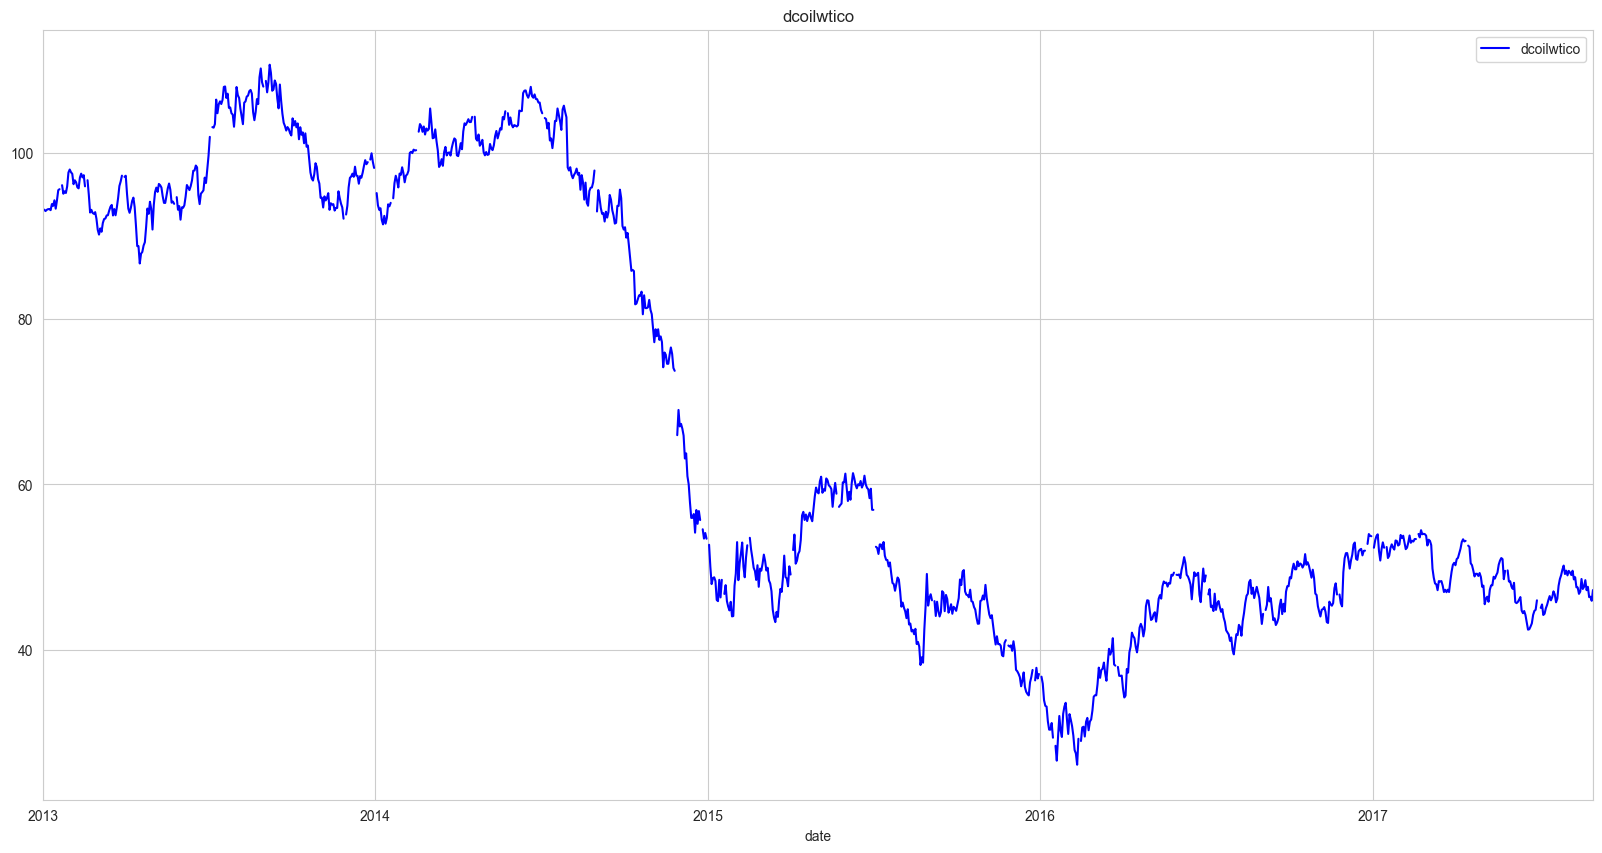

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df_oil.plot.line(x="date", y="dcoilwtico", color='b', title ="dcoilwtico", ax = axes, rot=0)
plt.show()